# Unsupervised learning

### The goal of the notebook is to research some models x features sets out of *.pcaps

In [37]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import collections
import seaborn as sns
import pprint
import os
import ipywidgets
import warnings

import pyshark
import networkx as nx

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import umap

from itertools import product

# PATH change to access library cyberlib
import sys
sys.path.append('/home/benjamin/Folders_Python/Cyber/libs')
import cyberlib as cbl

In [2]:
# logging set-up

lg = cbl.GetLogger('/home/benjamin/Folders_Python/Cyber/logs/unsupervised_learning.log')
logger = lg.get_custom_logger()

# start your engine
logger.info("-------- new run --------")

### Get the *.pcap to play with

In [3]:
DFNAME = 'smallFlows'

PCAPFILE = '/home/benjamin/Folders_Python/Cyber/data/input_pcaps/' + DFNAME + '.pcap'

In [4]:
capture = pyshark.FileCapture(
    input_file=PCAPFILE,
    use_ek=False
)

logger.info(f'-- created a capture object in PyShark with pcap file = {PCAPFILE} --')

In [5]:
pp = pprint.PrettyPrinter(indent=4)

for id in range(5):
    p = cbl.PyPacket(capture[id])
    pp.pprint(p.data)
    print('-------------')

{   'ETH': {   'dst': '00:1a:8c:15:f9:80',
               'src': '40:61:86:9a:f1:f5',
               'type': '0x00000800'},
    'IP': {   'dst': '72.14.213.138',
              'flags': '0x00000040',
              'hdr_len': '20',
              'id': '0x000076e0',
              'len': '983',
              'proto': '6',
              'src': '192.168.3.131',
              'ttl': '128',
              'version': '4'},
    'TCP': {   'ack': '1',
               'dstport': '80',
               'flags': '0x00000018',
               'hdr_len': '20',
               'len': '943',
               'payload': '47:45:54:20:2f:63:6f:6d:70:6c:65:74:65:2f:73:65:61:72:63:68:3f:63:6c:69:65:6e:74:3d:63:68:72:6f:6d:65:26:68:6c:3d:65:6e:2d:55:53:26:71:3d:63:72:20:48:54:54:50:2f:31:2e:31:0d:0a:48:6f:73:74:3a:20:63:6c:69:65:6e:74:73:31:2e:67:6f:6f:67:6c:65:2e:63:61:0d:0a:43:6f:6e:6e:65:63:74:69:6f:6e:3a:20:6b:65:65:70:2d:61:6c:69:76:65:0d:0a:55:73:65:72:2d:41:67:65:6e:74:3a:20:4d:6f:7a:69:6c:6c:61:2f:35:2e:30:20

### Choice of features

We will look at Ethernet packets part of a TCP conversation

Features at TCP level : source port, destination port, sequence number, acknowledgement number, flags, header length, total length, time delta since last packet, time delta since first packet

Features at IP level : source IP, destination IP, flags, header length, length, identification, ttl, version

Features at ETH level : None

In [6]:
DIRDATAFRAMES = '/home/benjamin/Folders_Python/Cyber/data/dataframes/'
filename = DIRDATAFRAMES + 'df_raw_' + DFNAME + '.pkl'

if os.path.isfile(filename):
    df_raw = pd.read_pickle(filename)
    logger.info('read an existing dataframe for unsupervised learning')
else:
    df_raw = cbl.GetTCPDataframeFromFileCapture(filecapture=capture).dataframe
    df_raw.to_pickle(filename)
    logger.info('created and wrote a dataframe for unsupervised learning')

In [7]:
df_raw

,ETH_dst,ETH_src,IP_id,IP_flags,IP_src,IP_dst,TCP_flags,IP_version,IP_hdr_len,IP_len,...,TCP_srcport,TCP_dstport,TCP_stream,TCP_len,TCP_seq,TCP_ack,TCP_hdr_len,TCP_time_relative,TCP_time_delta,TIMESTAMP_ts
0,00:1a:8c:15:f9:80,40:61:86:9a:f1:f5,0x000076e0,0x00000040,192.168.3.131,72.14.213.138,0,4.0,20.0,983.0,...,57011.0,80.0,0.0,943.0,1.0,1.0,20.0,0.000000,0.000000,2011-01-25 19:52:22.484409
1,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,0x00002d62,0x00000000,72.14.213.138,192.168.3.131,0,4.0,20.0,426.0,...,80.0,57011.0,0.0,386.0,1.0,944.0,20.0,0.029841,0.029841,2011-01-25 19:52:22.514250
2,00:1a:8c:15:f9:80,40:61:86:9a:f1:f5,0x00002e9e,0x00000040,192.168.3.131,72.14.213.102,1,4.0,20.0,52.0,...,55950.0,80.0,1.0,0.0,0.0,0.0,32.0,0.000000,0.000000,2011-01-25 19:52:22.708292
3,00:1a:8c:15:f9:80,40:61:86:9a:f1:f5,0x000076ef,0x00000040,192.168.3.131,72.14.213.138,2,4.0,20.0,40.0,...,57011.0,80.0,0.0,0.0,944.0,387.0,20.0,0.229423,0.199582,2011-01-25 19:52:22.713832
4,40:61:86:9a:f1:f5,00:1a:8c:15:f9:80,0x00009415,0x00000000,72.14.213.102,192.168.3.131,3,4.0,20.0,52.0,...,80.0,55950.0,1.0,0.0,0.0,1.0,32.0,0.018766,0.018766,2011-01-25 19:52:22.727058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13703,52:54:00:12:35:02,08:00:27:cc:3f:1b,0x000088af,0x00000040,10.0.2.15,65.55.15.244,5,4.0,20.0,40.0,...,2537.0,5480.0,407.0,0.0,5039.0,5738.0,20.0,71.195375,66.560501,2011-01-25 19:57:20.768701
13704,52:54:00:12:35:02,08:00:27:cc:3f:1b,0x000088b0,0x00000040,10.0.2.15,207.46.105.186,5,4.0,20.0,40.0,...,2540.0,5480.0,409.0,0.0,398.0,93.0,20.0,70.606228,5.540471,2011-01-25 19:57:20.768769
13705,52:54:00:12:35:02,08:00:27:cc:3f:1b,0x000088b1,0x00000040,10.0.2.15,96.17.8.49,5,4.0,20.0,40.0,...,2547.0,5480.0,419.0,0.0,496.0,8189.0,20.0,64.405045,64.259982,2011-01-25 19:57:20.768861
13706,52:54:00:12:35:02,08:00:27:cc:3f:1b,0x000088b2,0x00000040,10.0.2.15,91.103.140.2,5,4.0,20.0,40.0,...,2546.0,5480.0,417.0,0.0,525.0,270.0,20.0,64.884164,64.357688,2011-01-25 19:57:20.768911


### Preprocessing : ordinal encoding, normalization

In [8]:
# ordinal encoding with Pandas

columns_to_encode_as_ordinal = ['ETH_dst', 'ETH_src', 'IP_id', 'IP_flags', 'IP_src', 'IP_dst']

df_ord = pd.DataFrame()
for c in columns_to_encode_as_ordinal:
    codes, _ = pd.factorize(df_raw[c])
    df_sup = pd.DataFrame(data={ c : list(codes) })
    df_ord = pd.concat([df_ord, df_sup], axis=1)
    
df = df_raw.drop(columns=columns_to_encode_as_ordinal)
df.reset_index(drop=True)

df = pd.concat([df, df_ord], axis=1)

columns_to_drop = ['TIMESTAMP_ts']
df.drop(columns=columns_to_drop, inplace=True)

df

,TCP_flags,IP_version,IP_hdr_len,IP_len,IP_ttl,IP_proto,TCP_srcport,TCP_dstport,TCP_stream,TCP_len,...,TCP_ack,TCP_hdr_len,TCP_time_relative,TCP_time_delta,ETH_dst,ETH_src,IP_id,IP_flags,IP_src,IP_dst
0,0,4.0,20.0,983.0,128.0,6.0,57011.0,80.0,0.0,943.0,...,1.0,20.0,0.000000,0.000000,0,0,0,0,0,0
1,0,4.0,20.0,426.0,52.0,6.0,80.0,57011.0,0.0,386.0,...,944.0,20.0,0.029841,0.029841,1,1,1,1,1,1
2,1,4.0,20.0,52.0,128.0,6.0,55950.0,80.0,1.0,0.0,...,0.0,32.0,0.000000,0.000000,0,0,2,0,0,2
3,2,4.0,20.0,40.0,128.0,6.0,57011.0,80.0,0.0,0.0,...,387.0,20.0,0.229423,0.199582,0,0,3,0,0,0
4,3,4.0,20.0,52.0,52.0,6.0,80.0,55950.0,1.0,0.0,...,1.0,32.0,0.018766,0.018766,1,1,4,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13703,5,4.0,20.0,40.0,128.0,6.0,2537.0,5480.0,407.0,0.0,...,5738.0,20.0,71.195375,66.560501,4,4,8862,0,48,68
13704,5,4.0,20.0,40.0,128.0,6.0,2540.0,5480.0,409.0,0.0,...,93.0,20.0,70.606228,5.540471,4,4,8863,0,48,70
13705,5,4.0,20.0,40.0,128.0,6.0,2547.0,5480.0,419.0,0.0,...,8189.0,20.0,64.405045,64.259982,4,4,8864,0,48,82
13706,5,4.0,20.0,40.0,128.0,6.0,2546.0,5480.0,417.0,0.0,...,270.0,20.0,64.884164,64.357688,4,4,8865,0,48,80


In [9]:
# the rest of the preprocessing with a scikit learn pipeline

pipe = Pipeline(
    [ ('normalize', StandardScaler() )]
)

In [10]:
X = df.to_numpy()
X_norm = pipe.fit_transform(X)

In [11]:
X_norm

array([[-1.46353242,  0.        ,  0.        , ..., -0.34007453,
        -1.04054793, -0.8734765 ],
       [-1.46353242,  0.        ,  0.        , ...,  2.94053187,
        -1.00925978, -0.84189776],
       [-0.55161867,  0.        ,  0.        , ..., -0.34007453,
        -1.04054793, -0.81031902],
       ...,
       [ 3.0960363 ,  0.        ,  0.        , ..., -0.34007453,
         0.46128342,  1.71598013],
       [ 3.0960363 ,  0.        ,  0.        , ..., -0.34007453,
         0.46128342,  1.65282265],
       [ 3.0960363 ,  0.        ,  0.        , ..., -0.34007453,
         0.46128342,  1.74755887]])

In [12]:
def viz3d(X_embedding, titre='visu 3D'):
    """Utility function to plot a 3D picture

    Args:
        X_embedding (_type_): _description_
    """
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')
    
    xs = X_embedding[:,0]
    ys = X_embedding[:,1]
    zs = X_embedding[:,2]
    
    ax.scatter3D(xs, ys, zs)
    ax.set_title(titre)
    
    plt.show()
    
    return fig, ax

### Vizualization : PCA, t-SNE

Variance per principal component : ['21.3%', '15.5%', '12.8%']%


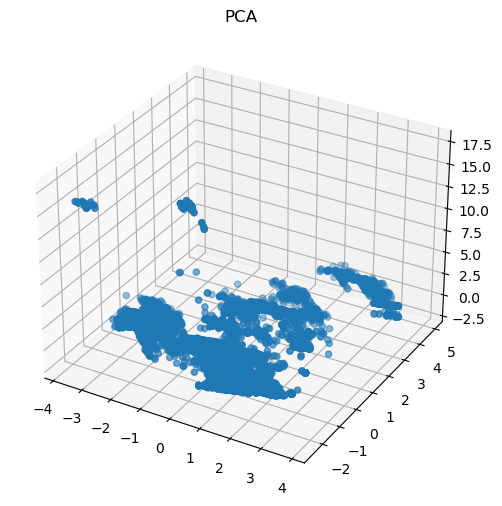

In [13]:
pca = PCA(
    n_components = 3
)

X_new = pca.fit_transform(X_norm)

expl = [ r*100 for r in pca.explained_variance_ratio_ ]
expl_s = [ f'{e:.1f}%' for e in expl ]
print(f'Variance per principal component : {expl_s}%')

viz3d(X_new, 'PCA')
plt.show()

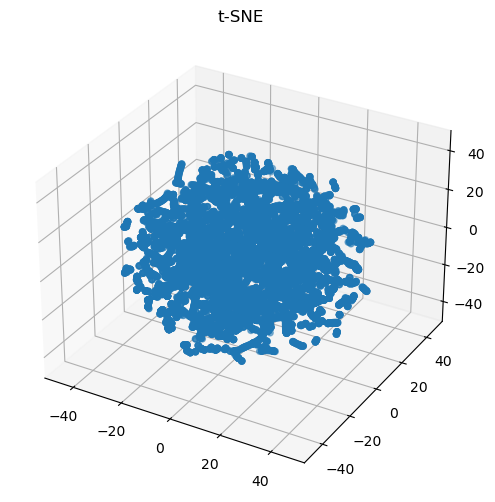

In [14]:
X_new = TSNE(
    n_components=3, 
    learning_rate='auto',
    perplexity=10  # reltaed to the number of neighbors used in other manifold learning algorithms. Highly sensitve parameter.
    ).fit_transform(X_norm)

viz3d(X_new, 't-SNE')
plt.show()

### Clustering

k-means

In [15]:
# finding a good number of clusters

MAX_CLUSTERS = 100
range_clusters = range(2, MAX_CLUSTERS+1)

silhouette = np.zeros(shape=(MAX_CLUSTERS-1))

for n_clusters in range_clusters:
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        init='k-means++', # educated attempt to have a good initialization
        n_init=1  # because k-means++
        )
    labels = kmeans.fit_predict(X_norm)
    silhouette[n_clusters-2] = silhouette_score(X_norm, labels)
    print(f'Silhouette score for {n_clusters} clusters = {silhouette[n_clusters-2]}')
    
n_cluster_opt = np.argmax(silhouette) + 2
print(f'Nb clusters retenu = {n_cluster_opt}')

Silhouette score for 2 clusters = 0.23172365270858641
Silhouette score for 3 clusters = 0.27799074241913174
Silhouette score for 4 clusters = 0.27037034177234975
Silhouette score for 5 clusters = 0.2940218171892787
Silhouette score for 6 clusters = 0.30304311250212457
Silhouette score for 7 clusters = 0.29394629090361274
Silhouette score for 8 clusters = 0.2935230304395422
Silhouette score for 9 clusters = 0.31285494471941
Silhouette score for 10 clusters = 0.30673493781815975
Silhouette score for 11 clusters = 0.30293198915559405
Silhouette score for 12 clusters = 0.32038415574844714
Silhouette score for 13 clusters = 0.33089985251951287
Silhouette score for 14 clusters = 0.35307834651981684
Silhouette score for 15 clusters = 0.35372228443772163
Silhouette score for 16 clusters = 0.3709251706708553
Silhouette score for 17 clusters = 0.3769961714222242
Silhouette score for 18 clusters = 0.3882487862165808
Silhouette score for 19 clusters = 0.395776420525682
Silhouette score for 20 clus

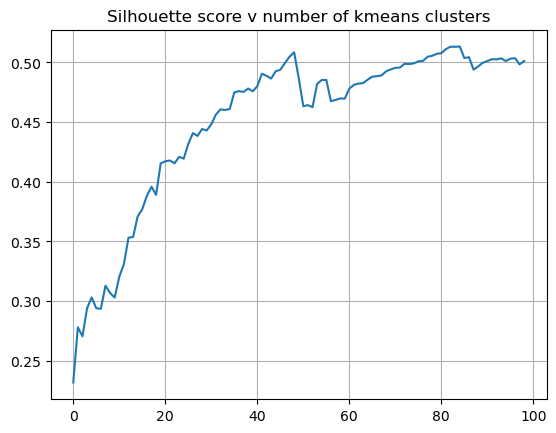

In [16]:
fig, ax = plt.subplots()

ax.plot(silhouette)
ax.grid(True)
ax.set_title('Silhouette score v number of kmeans clusters')
plt.show()

In [17]:
kmeans = KMeans(
    n_clusters=n_cluster_opt,
    random_state=0,
    init='k-means++', # educated attempt to have a good initialization
    n_init=1  # because k-means++
)

In [18]:
def visu3d(X_norm=X_norm, model=None, labels=None, titre='Visu 3d'):
    """Utility function to plot the 3d PCA projection of the trained model with clusters labels

    Args:
        X_norm (_type_, optional): _description_. Defaults to X_norm.
        model (_type_, optional): _description_. Defaults to None.
        labels (_type_, optional): _description_. Defaults to None.
    """
    
    unique_labels = np.unique(labels)
    
    pca = PCA(n_components = 3)
    X_embedding = pca.fit_transform(X_norm)
    
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')

    xs = X_embedding[:,0]
    ys = X_embedding[:,1]
    zs = X_embedding[:,2]

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    c = [ colors[labels[i]] if labels[i] >= 0 else [0,0,0,1] for i in range(len(labels)) ]
        
    ax.scatter3D(xs, ys, zs, color=c)
    n_clusters = len(set(unique_labels)) - (1 if -1 in labels else 0)
    titre = titre + f' {n_clusters} clusters'
    ax.set_title(titre)
        
    plt.show()
    
    return fig, ax

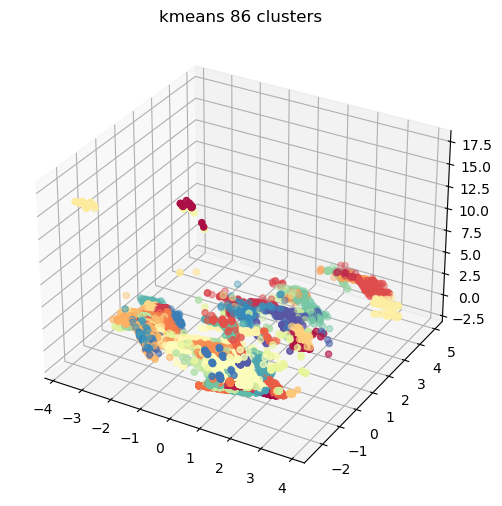

In [19]:
labels = kmeans.fit_predict(X_norm)

fig, ax = visu3d(
    X_norm=X_norm,
    model=kmeans,
    labels=kmeans.fit_predict(X_norm),
    titre=f'kmeans'
)

DBSCAN

In [20]:
# finding a good pair of Epsilon x Min_samples parameters

# epsilons
distances = pairwise_distances(X_norm, X_norm).flatten() # compute all the euclidian distances between two points in X_norm
dmax = np.max(distances)
print(f'max distance between two points in feature space = {dmax}')
N_EPSILONS = 5
epsilons_range = np.linspace(dmax/100.0, dmax/20.0, num=N_EPSILONS)
# print(epsilons_range)

# minimum samples
n_samples = X_norm.shape[0]
N_MIN_SAMPLES = 10
n_min_samples = np.max( [2,n_samples/2000] )
n_max_samples = np.max( [n_samples/100, n_min_samples+1] )
min_samples_range = np.linspace(n_min_samples, n_max_samples, num=N_MIN_SAMPLES).astype('int')
# print(min_samples_range)

# silhouettes calculations
silhouette_max = -1.0

for epsilon, min_samples in product(epsilons_range, min_samples_range):
    print(f'-----------------------------------------------------')
    print(f'n_samples = {min_samples}, epsilon = {epsilon}')
    
    db = DBSCAN(
        eps=epsilon,
        min_samples=min_samples
        )
    
    labels = db.fit_predict(X_norm)
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  # number of found clusters (without -1 which is the label for noise
    n_noise_ = list(labels).count(-1)  # number of noisy points
    noise_ratio = n_noise_/n_samples
    
    print(f'number of clusters found is {n_clusters_}')
    print(f'number of noise points found is {n_noise_} out of {n_samples} total (ie {noise_ratio*100:.2f}%)')
    
    if len(set(labels)) >= 2:
        s = silhouette_score(X_norm, labels)
        print(f'Silhouette score for {n_clusters_} clusters = {s:.3f}')
    else:
        print(f'Not calulating silhouette score as only one label found')
    
    if s > silhouette_max:
        silhouette_max = s
        opt_n_clusters = n_clusters_
        opt_eps = epsilon
        opt_min_samples = min_samples
        opt_noise_ratio = noise_ratio
        
print(f'====================================================================================================')
print(f'Best silhouette score is {silhouette_max} with {opt_n_clusters} clusters and {opt_noise_ratio*100:.2f}% noise, for epsilon = {opt_eps} and min_samples = {opt_min_samples}')

max distance between two points in feature space = 44.13678064066027
-----------------------------------------------------
n_samples = 6, epsilon = 0.44136780640660267
number of clusters found is 207
number of noise points found is 1671 out of 13708 total (ie 12.19%)
Silhouette score for 207 clusters = 0.302
-----------------------------------------------------
n_samples = 21, epsilon = 0.44136780640660267
number of clusters found is 82
number of noise points found is 3751 out of 13708 total (ie 27.36%)
Silhouette score for 82 clusters = 0.231
-----------------------------------------------------
n_samples = 35, epsilon = 0.44136780640660267
number of clusters found is 46
number of noise points found is 5257 out of 13708 total (ie 38.35%)
Silhouette score for 46 clusters = 0.147
-----------------------------------------------------
n_samples = 50, epsilon = 0.44136780640660267
number of clusters found is 32
number of noise points found is 6364 out of 13708 total (ie 46.43%)
Silhouette 

In [21]:
print(f'Running DBSCAN with epsilon = {opt_eps} and min_samples = {opt_min_samples}.\nSilhouette score is {silhouette_max} with {opt_n_clusters} clusters and {opt_noise_ratio*100:.2f}% noise')

db = DBSCAN(
    eps=opt_eps,
    min_samples=opt_min_samples
)

labels = db.fit_predict(X_norm)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  # number of found clusters (without -1 which is the label for noise)
n_noise_ = list(labels).count(-1)  # number of noisy points
n_points = X_norm.shape[0]

print(f'=> number of clusters found is {n_clusters_}')
print(f'=> number of noise points found is {n_noise_} out of {n_points} total (ie {n_noise_/n_points*100:.2f}%)')

Running DBSCAN with epsilon = 0.8827356128132053 and min_samples = 21.
Silhouette score is 0.3305742160842757 with 68 clusters and 11.34% noise
=> number of clusters found is 68
=> number of noise points found is 1555 out of 13708 total (ie 11.34%)


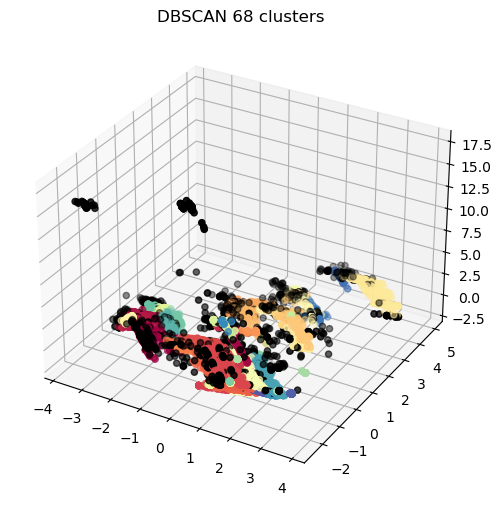

In [22]:
labels = db.fit_predict(X_norm)

fig, ax = visu3d(
    X_norm=X_norm,
    model=db,
    labels=db.fit_predict(X_norm),
    titre=f'DBSCAN'
)

### Gaussian Mixtures

In [23]:
N_MAX_GAUSSIANS = 100
ng_bics = []
bics = []

for i in range(1, N_MAX_GAUSSIANS, 5):
    n_gaussians = i+1
    gm = GaussianMixture(
        n_components=n_gaussians,
        covariance_type='full',
        random_state=42
        )
    
    labels = gm.fit_predict(X_norm)
    bic = gm.bic(X_norm)
    print(f'Model with {n_gaussians} gaussian(s) : BIC score = {bic:.0f}')
    
    ng_bics.append(n_gaussians)
    bics.append(bic)
    
opt_n_gaussians = ng_bics[np.argmin(bics)]
print(f'Best BIC score with {opt_n_gaussians}')

# BIC : https://scikit-learn.org/stable/modules/linear_model.html#aic-bic

Model with 2 gaussian(s) : BIC score = -637110
Model with 7 gaussian(s) : BIC score = -1437073
Model with 12 gaussian(s) : BIC score = -1758143
Model with 17 gaussian(s) : BIC score = -1869574
Model with 22 gaussian(s) : BIC score = -1934929
Model with 27 gaussian(s) : BIC score = -2013198
Model with 32 gaussian(s) : BIC score = -2101382
Model with 37 gaussian(s) : BIC score = -2119333
Model with 42 gaussian(s) : BIC score = -2124037
Model with 47 gaussian(s) : BIC score = -2131004
Model with 52 gaussian(s) : BIC score = -2158236
Model with 57 gaussian(s) : BIC score = -2189629
Model with 62 gaussian(s) : BIC score = -2155391
Model with 67 gaussian(s) : BIC score = -2162971
Model with 72 gaussian(s) : BIC score = -2187606
Model with 77 gaussian(s) : BIC score = -2189381
Model with 82 gaussian(s) : BIC score = -2198360
Model with 87 gaussian(s) : BIC score = -2218197
Model with 92 gaussian(s) : BIC score = -2214839
Model with 97 gaussian(s) : BIC score = -2192108
Best BIC score with 87


Best BIC score -2218197 with 87 gaussians


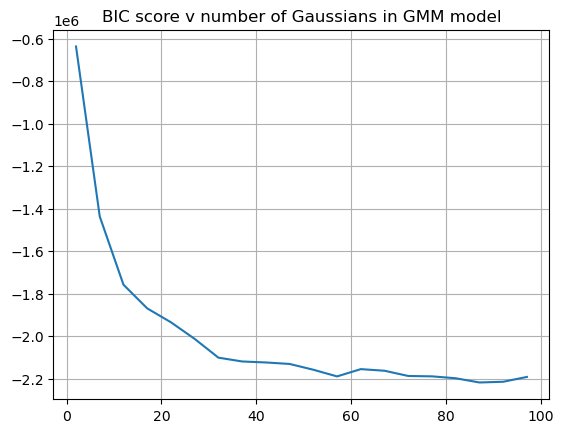

In [24]:
opt_n_gaussians = ng_bics[np.argmin(bics)]
print(f'Best BIC score {np.min(bics):.0f} with {opt_n_gaussians} gaussians')

fig, ax = plt.subplots()

ax.plot(ng_bics, bics)
ax.grid(True)
ax.set_title(f'BIC score v number of Gaussians in GMM model')
plt.show()

In [25]:
gm = GaussianMixture(
    n_components=opt_n_gaussians,
    covariance_type='full',
    random_state=42
)

labels = gm.fit_predict(X_norm)

print(f'BIC score = {gm.bic(X_norm):.2f}')

BIC score = -2218196.72


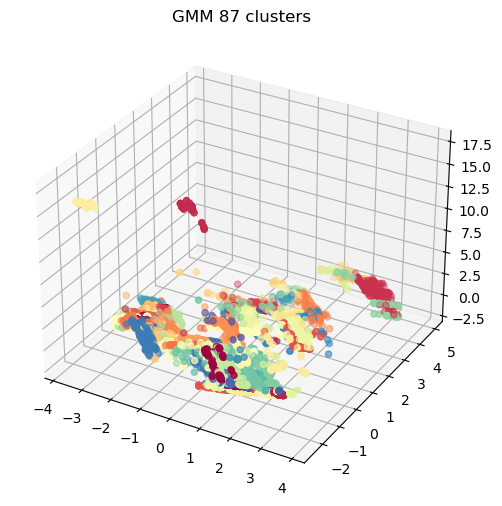

In [26]:
fig, ax = visu3d(
    X_norm=X_norm,
    model=gm,
    labels=labels,
    titre=f'GMM'
)

### UMAP : Manifold Learning => ~ visualization

In [43]:
# DOC : https://umap.scikit-tda.org/index.html

def visu_umap(
    n_neighbors=10,
    min_dist=0.1,
    # X_norm=X_norm
):
    """Utility function to use UMAP for 3D visualization

    Args:
        n_neighbors (int, optional): _description_. Defaults to 10.
        n_components (int, optional): _description_. Defaults to 3.
        min_dist (float, optional): _description_. Defaults to 0.1.
        random_state (int, optional): _description_. Defaults to 42.
    """
    
    warnings.filterwarnings("ignore")
    
    umap_instance = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=3,
        min_dist=min_dist,
        random_state=42
        )
    
    X_new = umap_instance.fit_transform(X_norm)
    
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')

    xs = X_new[:,0]
    ys = X_new[:,1]
    zs = X_new[:,2]
            
    ax.scatter3D(xs, ys, zs) #, color=c)
    titre = f'UMAP - {n_neighbors} neigbhors, {min_dist} min dist'
    ax.set_title(titre)
            
    plt.show()
    
    # return fig, ax

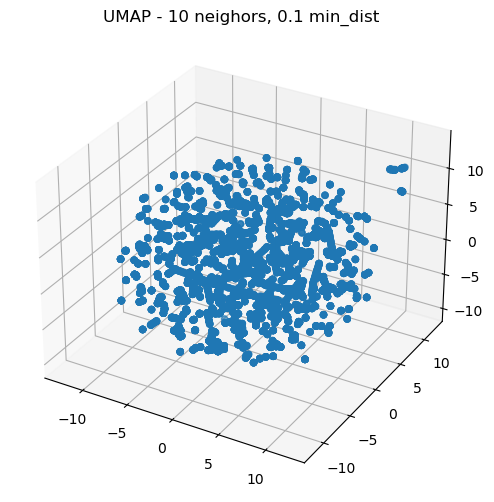

In [38]:
warnings.filterwarnings("ignore")
visu_umap()

In [42]:
ipywidgets.interact(
    visu_umap,
    n_neighbors = (5,100,10),
    min_dist = (0.1,1.0,0.05)
)

interactive(children=(IntSlider(value=10, description='n_neighbors', min=5, step=10), FloatSlider(value=0.1, d…

<function __main__.visu_umap(n_neighbors=10, min_dist=0.1)>